<a href="https://colab.research.google.com/github/awitz23/Project_CS-GO/blob/main/uffff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install Pillow==9.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.3 MB 7.2 MB/s 
  Attempting uninstall: Pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
%%shell
add-apt-repository -y ppa:longsleep/golang-backports
apt -y update
apt -y install golang-go

pip install awpy

#wget https://storage.googleapis.com/csgo-tests/default.dem

Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease [1,581 B]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [787 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelea

In [3]:
import pandas as pd
import numpy as np

#from awpy.parser import DemoParser
from awpy import *
#from awpy.data import NAV_CSV --> evtl. nicht notwendig, mal ausprobieren

from google.colab import drive
from google.colab import files
drive.mount('/content/drive')

p = DemoParser(demofile="/content/drive/MyDrive/Demofiles/vitality-vs-liquid-m2-dust2.dem", parse_rate=128)

from awpy.data import NAV_CSV


pd.set_option('max_rows', 200)
pd.set_option('max_colwidth', 4000)
pd.describe_option('max_colwidth')

Mounted at /content/drive
display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 4000]


In [4]:
d = p.parse()
d.keys()
df = p.parse(return_type="df")
df.keys()

dict_keys(['matchID', 'clientName', 'mapName', 'tickRate', 'playbackTicks', 'rounds', 'kills', 'damages', 'grenades', 'flashes', 'weaponFires', 'bombEvents', 'frames', 'playerFrames'])

#AB HIER: Versuch 
1. Spieler lokalisieren (X & Y Koord. Suchen)
2. Genauen Bereich lokalisieren (Durch NAV File)

In [93]:
#1. Spieler lokalisieren und erste 20 sek. tracken

player= df["playerFrames"]


track3 = player#.loc[(player['roundNum'] == 1)]
track4 = track3[(track3['seconds'] > 0) & (track3['seconds'] <= 20)]
track5 = track4.loc[
                    #(player['name'] == "shox") & 
                    (track4["seconds"]<14)&
                    (track4["seconds"]>13)] 
#track5 entspricht dem DF für Spieler shox der Sekunden 0-20 --> alle Bewegungen und Aktionen der ersten 20 Sekunden

track4 = track4.loc[track4["roundNum"]==19] 
#track4 = track4.loc[track4["side"]=="T"]

In [94]:
#2. Suche Position d. Spielers in NAV Datei

#ziehe Daten der Map
t = NAV_CSV[NAV_CSV["mapName"] == "de_dust2"]

#loaklisiere Spieler
f = t[(t['northWestX'] > track5.iloc[0]["x"]-80) & (t['northWestX'] < track5.iloc[0]["x"]+80)]
f = f[(f['northWestY'] > track5.iloc[0]["y"]-80) & (f['northWestY'] < track5.iloc[0]["y"]+80)]

#nehme nur eine Position, die die am häufigsten auftritt, da durch Z-Koord. diese häufiger auftreten. Durch höchste Anzahl sollte die richtige koord. gewählt werden
loc = f["areaName"].value_counts().idxmax()



In [95]:
#track5 = track5.reset_index() 

#Finde Positionen für alle Spieler in den ersten 20 sekunden zu jeder sekunde

#initialisiere leere Liste um später Positionen einzuspeichern
area = []
#für jede Reihe durchgehen und Position festlegen und in Liste einspeichern --> jede Sekunde für jeden Spieler
for index, row in track4.iterrows():
  f = t[(t['northWestX'] > row['x']-80) & (t['northWestX'] < row['x']+80)]
  f = f[(f['northWestY'] > row['y']-80) & (f['northWestY'] < row['y']+80)]
  
  if f.empty:
    loc = "MISTAKE"
    area.append(loc)
    
  else:
    loc = f["areaName"].value_counts().idxmax()
    area.append(loc)

#füge Liste mit Positionen zu DF hinzu
track4["area"] = area 

    

In [8]:

#track4["area"] = area 
#track4["area"].value_counts()
#check = track4.loc[track4["area"]==""]


#vllt nochmal mit Liste versuchen, sorgt aber für Probleme hier, darum nicht mehr, aber code mal lassen

Mid = ["MidDoors", "TopofMid", "Middle", "CTSpawn", "Short"]
Short = ["ShortStairs", "UnderA", "ExtendedA", "Catwalk"]
BombB = ["BombsiteB", "BDoors", "Hole"]
TerroristSpawn = ["TSpawn", "TRamp"]
Tunnel = ["OutsideTunnel", "UpperTunnel", "TunnelStairs", "LowerTunnel"]
Long = ["LongA", "LongDoors", "OutsideLong", "Pit", "Side"]
BombA = ["BombsiteA", "ARamp","Ramp"]
i=0
po = []
for index, row in track4.iterrows():
  if track4.at[i,'area'] in Mid:
    e = "Mid"
    po.append(e)
    print(po)
    i = i+1
  elif track4.at[i,'area'] in Short:
    e = "Short"
    po.append(po)
    i = i+1
  elif track4.at[i,'area'] in BombB:
    e = "BombB"
    po.append(e)
    i = i+1
  elif track4.at[i,'area'] in TerroristSpawn:
    e = "TerroristSpawn"
    po.append(e)
    i = i+1
  elif track4.at[i,'area'] in Tunnel:
    e = "Tunnel"
    po.append(e)
    i = i+1
  elif track4.at[i,'area'] in Long:
    e = "Long"
    po.append(e)
    i = i+1
  elif track4.at[i,'area'] in BombA:
    e = "BombA"
    po.append(e)
    i = i+1
  else:
    e = "ERROR"
    po.append(e)
    i = i+1
  
track4["eeee"] = po

In [96]:
#Group into Subgroups
#merke: Short und Long in A umwandeln ! Tunnel in B
track4.loc[track4['area'] == "CTSpawn",'subgroup'] = "Mid"
track4.loc[track4['area'] == "MidDoors",'subgroup'] = "BombB"
track4.loc[track4['area'] == "TopofMid",'subgroup'] = "Mid"
track4.loc[track4['area'] == "Middle",'subgroup'] = "Mid"
track4.loc[track4['area'] == "Short",'subgroup'] = "Mid"

track4.loc[track4['area'] == "ShortStairs",'subgroup'] = "BombA"
track4.loc[track4['area'] == "UnderA",'subgroup'] = "BombA"
track4.loc[track4['area'] == "ExtendedA",'subgroup'] = "BombA"
track4.loc[track4['area'] == "Catwalk",'subgroup'] = "BombA"

track4.loc[track4['area'] == "BombsiteB",'subgroup'] = "BombB"
track4.loc[track4['area'] == "BDoors",'subgroup'] = "BombB"
track4.loc[track4['area'] == "Hole",'subgroup'] = "BombB"

track4.loc[track4['area'] == "TSpawn",'subgroup'] = "TerroristSpawn"
track4.loc[track4['area'] == "TRamp",'subgroup'] = "TerroristSpawn"

track4.loc[track4['area'] == "OutsideTunnel",'subgroup'] = "BombB"
track4.loc[track4['area'] == "UpperTunnel",'subgroup'] = "BombB"
track4.loc[track4['area'] == "TunnelStairs",'subgroup'] = "BombB"
track4.loc[track4['area'] == "LowerTunnel",'subgroup'] = "BombB"

track4.loc[track4['area'] == "LongA",'subgroup'] = "BombA"
track4.loc[track4['area'] == "LongDoors",'subgroup'] = "BombA"
track4.loc[track4['area'] == "OutsideLong",'subgroup'] = "BombA"
track4.loc[track4['area'] == "Pit",'subgroup'] = "BombA"
track4.loc[track4['area'] == "Side",'subgroup'] = "BombA"

track4.loc[track4['area'] == "BombsiteA",'subgroup'] = "BombA"
track4.loc[track4['area'] == "ARamp",'subgroup'] = "BombA"
track4.loc[track4['area'] == "Ramp",'subgroup'] = "BombA"

#df.loc[df['days'] <=20,'subgroup'] = 3
#df.loc[df['days'] <=10,'subgroup'] = 2
#df.loc[df['days'] ==0,'subgroup'] = 1
#df = df.reset_index()
#df['dynamic_subgroup'] = df.groupby(['group'])['subgroup'].rank(method='dense')
track4

,roundNum,tick,seconds,side,teamName,steamID,name,team,x,y,...,cashSpendTotal,hasHelmet,hasDefuse,hasBomb,ping,zoomLevel,matchID,mapName,area,subgroup
18040,19,293427,0.228346,CT,Vitality,76561197983956651,Magisk,Vitality,312.033783,2430.440918,...,53300,True,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,ExtendedA,BombA
18041,19,293427,0.228346,CT,Vitality,76561198113666193,ZywOo,Vitality,175.660568,2415.964111,...,48550,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,MISTAKE,NaN
18042,19,293427,0.228346,CT,Vitality,76561198004854956,dupreeh,Vitality,343.095703,2329.039551,...,50950,True,False,False,3,0,vitality-vs-liquid-m2-dust2,de_dust2,CTSpawn,Mid
18043,19,293427,0.228346,CT,Vitality,76561197989744167,apEX,Vitality,280.577423,2472.048096,...,46150,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,ExtendedA,BombA
18044,19,293427,0.228346,CT,Vitality,76561198081528911,misutaaa,Vitality,183.391922,2363.883545,...,52000,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,CTSpawn,Mid
18045,19,293427,0.228346,T,Team Liquid,76561198066693739,EliGE,Team Liquid,-408.779510,-849.837952,...,49500,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,TSpawn,TerroristSpawn
18046,19,293427,0.228346,T,Team Liquid,76561198047472534,oSee,Team Liquid,-1052.110352,-841.481506,...,43100,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,TSpawn,TerroristSpawn
18047,19,293427,0.228346,T,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-995.425537,-735.641418,...,44500,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,TSpawn,TerroristSpawn
18048,19,293427,0.228346,T,Team Liquid,76561198006920295,shox,Team Liquid,-512.469116,-741.609741,...,45050,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,TSpawn,TerroristSpawn
18049,19,293427,0.228346,T,Team Liquid,76561197995889730,nitr0,Team Liquid,-344.877228,-803.736084,...,44500,False,False,True,5,0,vitality-vs-liquid-m2-dust2,de_dust2,TSpawn,TerroristSpawn


In [103]:
che = track4.loc[track4["side"]== "CT"]
che

,roundNum,tick,seconds,side,teamName,steamID,name,team,x,y,...,cashSpendTotal,hasHelmet,hasDefuse,hasBomb,ping,zoomLevel,matchID,mapName,area,subgroup
18040,19,293427,0.228346,CT,Vitality,76561197983956651,Magisk,Vitality,312.033783,2430.440918,...,53300,True,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,ExtendedA,BombA
18041,19,293427,0.228346,CT,Vitality,76561198113666193,ZywOo,Vitality,175.660568,2415.964111,...,48550,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,MISTAKE,NaN
18042,19,293427,0.228346,CT,Vitality,76561198004854956,dupreeh,Vitality,343.095703,2329.039551,...,50950,True,False,False,3,0,vitality-vs-liquid-m2-dust2,de_dust2,CTSpawn,Mid
18043,19,293427,0.228346,CT,Vitality,76561197989744167,apEX,Vitality,280.577423,2472.048096,...,46150,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,ExtendedA,BombA
18044,19,293427,0.228346,CT,Vitality,76561198081528911,misutaaa,Vitality,183.391922,2363.883545,...,52000,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,CTSpawn,Mid
18050,19,293555,1.236220,CT,Vitality,76561198113666193,ZywOo,Vitality,231.893845,2268.301025,...,48750,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,MISTAKE,NaN
18051,19,293555,1.236220,CT,Vitality,76561197983956651,Magisk,Vitality,145.764572,2268.718018,...,53300,True,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,CTSpawn,Mid
18052,19,293555,1.236220,CT,Vitality,76561197989744167,apEX,Vitality,438.141968,2301.634766,...,46150,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,MISTAKE,NaN
18053,19,293555,1.236220,CT,Vitality,76561198081528911,misutaaa,Vitality,402.424225,2281.103516,...,52000,True,True,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2,CTSpawn,Mid
18054,19,293555,1.236220,CT,Vitality,76561198004854956,dupreeh,Vitality,195.041748,2143.953125,...,50950,True,False,False,3,0,vitality-vs-liquid-m2-dust2,de_dust2,ExtendedA,BombA


In [97]:
#zeigt count der orte der ersten 20 sekunden der spieler an, aber nur zum checken, glaube zu doof zum weiterbearbeiten
df2 = track4.groupby(['subgroup', 'name'])['subgroup'].count().unstack(fill_value=0)
print(df2)

name            EliGE  Magisk  NAF-FLY  ZywOo  apEX  dupreeh  misutaaa  nitr0  \
subgroup                                                                        
BombA               9       1        0      9    16        1        14      9   
BombB               0      16       13      4     0        8         0      0   
Mid                 0       2        0      2     2        3         2      0   
TerroristSpawn      2       0        3      0     0        0         0      5   

name            oSee  shox  
subgroup                    
BombA             14    15  
BombB              0     0  
Mid                0     1  
TerroristSpawn     6     2  


In [104]:
#Location Lists for CT-Side

CTBombA = list(track4[(track4['subgroup']=='BombA')&(track4["side"]=="CT")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, BombA: ", CTBombA)

CTBombB = list(track4[(track4['subgroup']=='BombB')&(track4["side"]=="CT")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, BombB: ", CTBombB)

CTMid = list(track4[(track4['subgroup']=='Mid')&(track4["side"]=="CT")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, Mid: ", CTMid)

CTTerroristSpawn = list(track4[(track4['subgroup']=='TerroristSpawn')&(track4["side"]=="CT")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, TerroristSpawn: ", CTTerroristSpawn)

#Lists for T-Side

TBombA = list(track4[(track4['subgroup']=='BombA')&(track4["side"]=="T")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, BombA: ", TBombA)

TBombB = list(track4[(track4['subgroup']=='BombB')&(track4["side"]=="T")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, BombB: ", TBombB)

TMid = list(track4[(track4['subgroup']=='Mid')&(track4["side"]=="T")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, Mid: ", TMid)

TTerroristSpawn = list(track4[(track4['subgroup']=='TerroristSpawn')&(track4["side"]=="T")].groupby(['name']).count()['subgroup'])
print("List for CT-Side Location Occurences, TerroristSpawn: ", TTerroristSpawn)

List for CT-Side Location Occurences, BombA:  [1, 9, 16, 1, 14]
List for CT-Side Location Occurences, BombB:  [16, 4, 8]
List for CT-Side Location Occurences, Mid:  [2, 2, 2, 3, 2]
List for CT-Side Location Occurences, TerroristSpawn:  []
List for CT-Side Location Occurences, BombA:  [9, 9, 14, 15]
List for CT-Side Location Occurences, BombB:  [13]
List for CT-Side Location Occurences, Mid:  [1]
List for CT-Side Location Occurences, TerroristSpawn:  [2, 3, 5, 6, 2]


In [81]:
#track4['subgroup'] = track4['subgroup'].mask(track4['subgroup'].ne('BombA'))
#track4.groupby(['side'])['subgroup'].count().tolist()

[41, 47]

In [ ]:
#Strategydetection

In [23]:
#zähle wie viele Spiele sich in welcher Region aufhalten

df1 = track4.groupby(['subgroup', 'seconds', 'name' ])['subgroup'].count().unstack(fill_value=0)
print(df1)


#track4 = track4.join(df1, on='subgroup')
#print(track4)



name                      EliGE  Magisk  NAF-FLY  ZywOo  apEX  dupreeh  \
subgroup       seconds                                                   
BombB          5.921260       0       0        1      0     0        0   
               6.929134       0       0        1      0     0        0   
               7.937008       0       0        1      0     0        0   
               8.944882       0       0        1      0     0        0   
               9.952756       0       0        1      0     0        0   
               10.960630      0       0        1      0     0        0   
               11.968504      0       0        1      0     0        0   
               12.976378      0       0        1      0     0        0   
               13.984252      0       0        1      0     0        0   
               14.992126      0       0        1      0     0        0   
               16.000000      0       0        1      0     0        0   
               17.007874      0       

#Hier: Diverser Müll

In [11]:
df["frames"]
f = df["frames"]

f.to_csv('f.csv') 
#files.download('f.csv')

In [12]:
from awpy.data import NAV_CSV

t = NAV_CSV[NAV_CSV["mapName"] == "de_dust2"]

t['areaName'].value_counts()

BombsiteB        129
TSpawn           127
OutsideTunnel     81
LongA             73
LongDoors         65
                  64
UpperTunnel       63
BDoors            60
MidDoors          59
TopofMid          42
BombsiteA         41
OutsideLong       40
TunnelStairs      32
TRamp             25
Middle            25
UnderA            25
ShortStairs       24
ARamp             23
Pit               23
CTSpawn           22
Side              18
ExtendedA         18
Catwalk           13
Hole              12
LowerTunnel        7
Ramp               6
Short              3
Name: areaName, dtype: int64

In [13]:
#f = t.loc[t["areaName"]=="BombsiteB"]
#f = f.sort_values("northWestX")
#f = f.loc[f["northWestY"]>=2800]
#f

#Suchfeld einschränken --> Position lokalisieren
f = t[(t['northWestX'] > 260) & (t['northWestX'] < 320)]
f = f[(f['northWestY'] > 2000) & (f['northWestY'] < 2300)]
f

,mapName,areaId,areaName,northWestX,northWestY,northWestZ,southEastX,southEastY,southEastZ
6325,de_dust2,8782,ExtendedA,300.0,2150.0,96.03125,525.0,2425.0,96.03125
7152,de_dust2,8781,ExtendedA,275.0,2150.0,96.03125,300.0,2425.0,96.03125
7153,de_dust2,303,Short,275.0,2100.0,96.03125,300.0,2150.0,96.03125
7230,de_dust2,95,ExtendedA,300.0,2025.0,96.03125,425.0,2150.0,96.03125


In [14]:
#Suche spezielle Werte

z = t.loc[t["areaId"]==1213]
X = z.iloc[0]["northWestX"]
Y = z.iloc[0]["northWestY"]

z

,mapName,areaId,areaName,northWestX,northWestY,northWestZ,southEastX,southEastY,southEastZ
7381,de_dust2,1213,BombsiteA,1050.0,2303.518799,128.03125,1125.0,2320.481201,128.03125


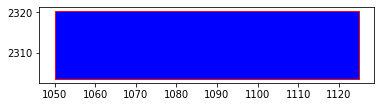

In [15]:
import matplotlib.pyplot as plt
plt.axes()

z = t.loc[t["areaId"]==1213]

z

rectangle = plt.Rectangle(((z.iloc[0]["southEastX"],z.iloc[0]["southEastY"])), -z.iloc[0]["southEastX"]+z.iloc[0]["northWestX"], z.iloc[0]["northWestY"]-z.iloc[0]["southEastY"], fc='blue',ec="red")
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.show()

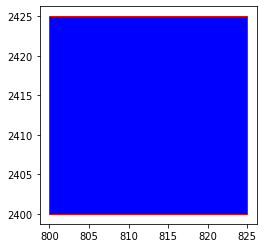

In [16]:
z = t.loc[t["areaId"]==8773]

z

rectangle = plt.Rectangle(((z.iloc[0]["southEastX"],z.iloc[0]["southEastY"])), -z.iloc[0]["southEastX"]+z.iloc[0]["northWestX"], z.iloc[0]["northWestY"]-z.iloc[0]["southEastY"], fc='blue',ec="red")
plt.gca().add_patch(rectangle)
plt.axis('scaled')
plt.show()

In [17]:
player= df["playerFrames"]


track3 = player.loc[player['roundNum'] == 1]
track4 = track3[(track3['seconds'] > 0) & (track3['seconds'] <= 20)]
track5 = track4.loc[player['name'] == "NAF-FLY"]

track4.to_csv('track4.csv') 
files.download('track4.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
track5

,roundNum,tick,seconds,side,teamName,steamID,name,team,x,y,...,cash,cashSpendThisRound,cashSpendTotal,hasHelmet,hasDefuse,hasBomb,ping,zoomLevel,matchID,mapName
4,1,1007,0.881890,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,279.738007,2130.619873,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
11,1,1135,1.889764,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,33.874302,2149.671631,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
20,1,1263,2.897638,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-211.960526,2176.251221,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
30,1,1391,3.905512,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-436.955170,2273.101562,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
40,1,1519,4.913386,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-671.717407,2340.496582,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
50,1,1647,5.921260,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-897.881226,2447.027588,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
63,1,1775,6.929134,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-1120.753784,2555.541748,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
70,1,1903,7.937008,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-1279.312866,2683.709717,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
80,1,2031,8.944882,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-1459.881226,2756.057861,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2
91,1,2159,9.952756,CT,Team Liquid,76561198001151695,NAF-FLY,Team Liquid,-1590.896729,2815.576904,...,150,650,650,False,False,False,5,0,vitality-vs-liquid-m2-dust2,de_dust2


In [19]:
roundCTTiles = list(df['playerFrames'][(df['playerFrames']['roundNum'] == 1) 
                    & (df['playerFrames']['side'] == 'CT') 
                    #& (df['playerFrames']['tick'] <= tmpRoundEndTick) 
                    #& (df['playerFrames']['isAlive'])].groupby(by = 'tick')['areaID']
                    .apply(list))


SyntaxError: ignored

In [ ]:
track6 = track5[["x","y"]]

track6=track6.values.tolist()

print(track6)

In [ ]:
track3.seconds = track3.seconds.round(3)
track3.x = track3.x.round(3)
#track3
#track3.to_csv('track3.csv') 
#files.download('track3.csv')

In [ ]:
#test2 = df["rounds"]



#test2.to_csv('test2.csv') 
#files.download('test2.csv')

In [ ]:
#kills2= df["kills"]

#kills_1 = kills2.loc[kills2['roundNum'] == 1]
#kills2.to_csv('kills2.csv') 
#files.download('kills2.csv')

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/Demofiles/track2.csv')


In [ ]:
#df_test.x = df_test.x.round(3)
#df_test

In [ ]:
import matplotlib.pyplot as plt
from awpy.visualization.plot import plot_map


f, a = plot_map(map_name="de_dust2", map_type="original")
plt.show()

In [ ]:
f, a = plot_map(map_name="de_dust2", map_type="simpleradar", dark=True)
plt.show()

In [ ]:
from awpy.visualization.plot import plot_nades

plot_nades(rounds=d["gameRounds"][1:25], nades=["Flashbang", "HE Grenade", "Smoke Grenade", "Molotov", "Incendiary Grenade"], side="CT", map_name="de_dust2", map_type="simpleradar", dark=False)


In [ ]:
d.keys()

In [ ]:
print(type(d["gameRounds"]))
dftest = pd.DataFrame(data={"col1": d["gameRounds"]})
#dftest.to_csv("dftest.csv")
#files.download('dftest.csv')

In [ ]:
dftest2 = pd.DataFrame(data={"col1": d["gameRounds"][0]})
dftest2.to_csv("dftest2.csv")
files.download('dftest2.csv')

In [ ]:
from awpy.visualization.plot import plot_positions

plot_positions(positions=track6, colors=["red"], markers=["s"], map_name='de_dust2', map_type='original', dark=False, apply_transformation=False)

HIER TEST VISUALISIERUNG

In [ ]:
import pandas as pd


import time
import json
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import patches
import imageio


demo_filepath = "/content/drive/MyDrive/Demofiles/vitality-vs-liquid-m2-dust2.dem"


demo_parser = DemoParser(demofile = demo_filepath, demo_id = "FAZE-C9-Inferno", parse_rate=128)


data_df = demo_parser.parse(return_type="df")

In [ ]:
def tile_values_snapshot(ctTilesWanted, tTilesWanted, neighborInfo):

    
    funcCTIds = [str(i) for i in list(ctTilesWanted)]
    funcTIds = [str(i) for i in list(tTilesWanted)]

    ### Run BFS For CT Tiles
    ctDict = {}
    for curId in funcCTIds:
        startVal = 10
        stepsize = 1
        tilesSeen = set()
        stack = []
        startingNode = (curId, startVal)
        stack.append(startingNode)
        while stack[0][1] > 0:
            curId, curVal = stack.pop(0)
            if curId not in tilesSeen:
                tilesSeen.add(curId)
                curTileValues = ctDict.get(int(curId), ([]))
                curTileValues.append(curVal/startVal)
                ctDict[int(curId)] = (curTileValues)
                for neighbor in neighborInfo[curId]:
                    stack.append((neighbor, curVal - stepsize))


    ### Run BFS For T Tiles
    tDict = {}
    for curId in funcTIds:
        
        startVal = 10
        stepsize = 1
        tilesSeen = set()
        stack = []
        startingNode = (curId, startVal)
        stack.append(startingNode)
        while stack[0][1] > 0:
            curId, curVal = stack.pop(0)
            if curId not in tilesSeen:
                tilesSeen.add(curId)
                curTileValues = tDict.get(int(curId), ([]))
                curTileValues.append(curVal/startVal)
                tDict[int(curId)] = (curTileValues)
                for neighbor in neighborInfo[curId]:
                    stack.append((neighbor, curVal - stepsize))
                    
    return ctDict, tDict


In [ ]:
filepath_cur = '/content/vitality-vs-liquid-m2-dust2.json'
# Opening JSON file
with open(filepath_cur) as json_file:
    data = json.load(json_file)


roundWanted = 25

tmpRoundBombPlanted = 'plant' in list(data_df['bombEvents'][data_df['bombEvents']['roundNum'] == roundWanted]['bombAction'])
if tmpRoundBombPlanted:
    tmpRoundBombTick = data_df['bombEvents'][(data_df['bombEvents']['roundNum'] == roundWanted) & (data_df['bombEvents']['bombAction'] == 'plant')]['tick'].iloc[0]
    
else:
    tmpRoundBombTick = None



In [ ]:
tmpRoundBeginTick = data_df['rounds'][data_df['rounds']['roundNum'] == roundWanted]['freezeTimeEndTick'].iloc[0]
tmpRoundEndTick = data_df['rounds'][data_df['rounds']['roundNum'] == roundWanted]['endOfficialTick'].iloc[0]


roundCTTiles = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'CT') & (data_df['playerFrames']['tick'] <= tmpRoundEndTick) & (data_df['playerFrames']['isAlive'])].apply(list))
roundTTiles = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'T') & (data_df['playerFrames']['tick'] <= tmpRoundEndTick) & (data_df['playerFrames']['isAlive'])].apply(list))

CT_x = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'CT') & (data_df['playerFrames']['tick'] <= tmpRoundEndTick) & (data_df['playerFrames']['isAlive'])].groupby('tick')['x'].apply(list))
CT_y = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'CT') & (data_df['playerFrames']['tick'] <= tmpRoundEndTick) & (data_df['playerFrames']['isAlive'])].groupby('tick')['y'].apply(list))
T_x = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'T') & (data_df['playerFrames']['tick'] <= tmpRoundEndTick) & (data_df['playerFrames']['isAlive'])].groupby('tick')['x'].apply(list))
T_y = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'T') & (data_df['playerFrames']['tick'] <= tmpRoundEndTick) & (data_df['playerFrames']['isAlive'])].groupby('tick')['y'].apply(list))

tmpRoundTickVals = list(data_df['playerFrames'][(data_df['playerFrames']['roundNum'] == roundWanted) & (data_df['playerFrames']['side'] == 'CT') & (data_df['playerFrames']['isAlive']) & (tmpRoundBeginTick <= data_df['playerFrames']['tick']) & (data_df['playerFrames']['tick'] <= tmpRoundEndTick)].groupby(by = 'tick').groups.keys())
tmpRoundSecArr = [(i - tmpRoundBeginTick) / 128 for i in tmpRoundTickVals]

print(len(roundCTTiles), len(roundTTiles), len(tmpRoundSecArr), len(tmpRoundTickVals))
combinedRoundTiles = zip(roundCTTiles, roundTTiles)
tileValuesRound = [tile_values_snapshot(i, j, data) for i, j in combinedRoundTiles]

In [ ]:





130 130 130 130
import math
def create_clocktimes(tickArr, roundTickStart, roundTickEnd, roundBombTick, tickRate, end_buffer = 0):
    '''
    Purpose: Function meant to estimate the in-game clock for a certain tick/frame within a round
    
    Inputs:
    
    tickArr -> Array of ticks in current round
    
    roundTickStart -> Tick where the round started. Should be the first tick after the buy phase (freezeTimeEndTick)
    
    roundTickEnd -> Tick where the round 'officially' ends (endOfficialTick)
    
    roundBombTick -> Tick where the bomb was planted. None if the bomb was not planted
    
    tickRate -> Tick rate at which the demo file was parsed
    
    end_buffer -> There is a brief amount of time after the round which players can still move
    around. This parameter is supposed to account for that. However, some demos/rounds are weird and have 
    different amounts of time at the end of the round (10 seconds, 15 seconds, etc.). I recommend
    using this parameter to fix any issues like that.
    
    Output:
    
    retArr -> Array of clocktimes corresponding to the ticks in tickArr
    
    '''
    retArr = []
    addedOnce = False
    for curTick in tickArr:
        if roundBombTick is not None:
            if curTick < roundBombTick:
                if curTick < roundTickEnd:
                    totalSeconds = 115 - (curTick - roundTickStart) / tickRate
                else:
                    totalSeconds = 10 - (curTick - roundTickEnd) / tickRate
            else:
                totalSeconds = 40 - (curTick - roundBombTick) / tickRate            
        else:
            if curTick < roundTickEnd:
                totalSeconds = 115 - (curTick - roundTickStart) / tickRate
            else:
                totalSeconds = 10 - (curTick - roundTickEnd) / tickRate
        if totalSeconds < 0:
            totalSeconds += end_buffer
            #print(totalSeconds)
            
        minutes = math.floor(max(totalSeconds, 0)/60)
        seconds = math.ceil((totalSeconds - 60*(minutes)))
        #print(totalSeconds, minutes, seconds, curTick, roundBombTick, roundTickEnd)
        retArr.append(str(minutes) + ':' + '0'* ((len(str(seconds)) * -1) + 2) + str(seconds))
    return retArr
tmpClockTimeArr = create_clocktimes(tmpRoundTickVals, tmpRoundBeginTick, tmpRoundEndTick, tmpRoundBombTick, data_df['tickRate'], end_buffer = 15)
print(len(tmpClockTimeArr))
130
Load in Nav Tile Metadata
# The map_nav.csv file is a csv with info on every tile on every map
# It can be found here: https://github.com/pnxenopoulos/csgo/blob/main/csgo/data/nav/map_nav.csv

tileInfo = pd.read_csv('../../../csgo/data/nav/map_nav.csv')
tileInfo
MapName	AreaId	AreaName	NorthWestX	NorthWestY	NorthWestZ	SouthEastX	SouthEastY	SouthEastZ	Connections	HidingSpots	EarliestOccupyTimeFirstTeam	EarliestOccupyTimeSecondTeam
0	de_ancient	152	Outside	260.60	642.80	-19.416094	280.60	627.80	18.666107	10	0	8.199903	15.538094
1	de_ancient	2559	MainHall	155.60	512.80	75.847092	160.60	502.80	72.037033	3	0	12.804793	13.120758
2	de_ancient	2748	Ruins	725.60	732.80	-29.636036	730.60	722.80	-15.349043	3	1	7.245784	19.397285
3	de_ancient	2835	Middle	540.60	477.80	65.784042	565.60	457.80	68.031197	2	1	13.451628	8.742879
4	de_ancient	2927	SideHall	315.60	507.80	103.918999	340.60	492.80	104.806747	2	0	15.876244	11.825044
...	...	...	...	...	...	...	...	...	...	...	...	...	...
10592	de_vertigo	4366	TSpawn	417.00	809.25	11488.031250	429.50	790.50	11488.031250	4	0	0.404472	17.929251
10593	de_vertigo	4446	Bridge	623.25	553.00	11501.278320	629.50	546.75	11488.031250	4	0	10.745050	16.382465
10594	de_vertigo	4490	BombsiteB	173.25	346.75	11776.031250	192.00	328.00	11776.031250	4	1	15.058154	8.052150
10595	de_vertigo	5000	ARamp	573.25	621.75	11573.395508	579.50	609.25	11560.895508	5	0	11.585015	14.865434
10596	de_vertigo	3294	ARamp	160.75	640.50	11488.031250	173.25	634.25	11488.031250	3	0	5.609235	19.288990
10597 rows × 13 columns

Calculate Extra Tile Data
currentMap = 'de_inferno'
curMapTile = tileInfo[(tileInfo['MapName'] == currentMap)]
curMapTile['TileWidth'] = curMapTile['SouthEastX'] - curMapTile['NorthWestX']
curMapTile['TileHeight'] = curMapTile['NorthWestY'] - curMapTile['SouthEastY']
curMapTile['TileArea'] = curMapTile['TileWidth'] * curMapTile['TileHeight']
tileToArea = {}
for i in range(len(curMapTile)):
    tileToArea[curMapTile['AreaId'].iloc[i]] = curMapTile['TileArea'].iloc[i]
#tileToArea
<ipython-input-64-46c40cc51063>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curMapTile['TileWidth'] = curMapTile['SouthEastX'] - curMapTile['NorthWestX']
<ipython-input-64-46c40cc51063>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curMapTile['TileHeight'] = curMapTile['NorthWestY'] - curMapTile['SouthEastY']
<ipython-input-64-46c40cc51063>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curMapTile['TileArea'] = curMapTile['TileWidth'] * curMapTile['TileHeight']
Visualize Map Control Snapshot(s)
Now that we have values from the CT and T team for each tile, now we need to map these values to a color value for plotting. For this example we will use Red for T and Green for CT. There are 4 possible cases:

a tile only has values from CT (within n tiles from at least one CT tile)
a tile only has values from T (within n tiles from at least 1 T tile)
a tile has values from both team (within n tiles from at least 1 T tile
and a tile doesn't have any values
If a tile only has values from one team, the max value is taken from its array of value. This max value is then mapped to a color by scaling the corresponding team's colors ([1, 0, 0] or [0, 1, 0] for this notebook) by the max value. Here's an example that might help. Let's say a tile T_0 has the following values [0.4, 0.8, 0.1] and all of these values were from the CT team. Then the max value for T_0 would be 0.8 and the color for the tile would be 0.8 * [0, 1, 0] = [0, 0.8, 0].

If a tile has values from both teams, the ratio between the sum of the CT values and the sum of both the CT and T values, or

 
Then, like before, this calculated value is linearly mapped to a color where 0 maps to [1, 0, 0] and 1 maps to [0, 1, 0].

def plot_map(map_name="de_dust2", map_type="original", dark=False, prevFig = None, prevAx = None):
    # Plots the simpleradar minimap for the wanted map. Code taken from csgo python library
    # which can be found here https://github.com/pnxenopoulos/csgo
    
    map_folder_path = "../../../csgo/data/map/"
    if map_type == "original":
        map_bg = plt.imread(map_folder_path + """{0}.png""".format(map_name))
    else:
        col = "light"
        if dark:
            col = "dark"
        map_bg = plt.imread(
            map_folder_path + """{0}_{1}.png""".format(map_name, col)
        )
    if prevFig and prevAx:
        prevAx.imshow(map_bg, zorder=0)
        return prevFig, prevAx
    else:
        fig, ax = plt.subplots()
        ax.imshow(map_bg, zorder=0)
        return fig, ax
def plot_map_control_snapshot(tileData, ctTiles, tTiles, map_name = 'de_dust2', useFig = None, useAx = None):
    """
    Purpose: Visualize map control for the current snapshot.
    Tile values are mapped to RGB colors and then plotted.
    
    Inputs:
    tileData -> Pandas df with nav tile metadata for the specific map
    
    ctTiles -> Dictionary mapping nav tile ID to its array of values
    from the CT team. Part of the output from tile_values_snapshot
    
    tTiles -> Dictionary mapping nav tile ID to its array of values
    from the T team. Part of the output from tile_values_snapshot
    
    map_name -> Name of map such that the correct minimap is plotted.
    Used for plot_map function
    
    Output(s):
    f, ax -> figure and axis objects used to visualize the current map control state
    """
    f, ax = plot_map(map_name = map_name, map_type = 'simpleradar', dark = True, prevFig = useFig, prevAx = useAx)
    ctTileLocs, tTileLocs = set(ctTiles.keys()), set(tTiles.keys())
    ctTileOnly, tTileOnly, bothTiles = ctTileLocs - tTileLocs, tTileLocs - ctTileLocs, ctTileLocs.intersection(tTileLocs)
    allRelevantTiles = ctTileLocs.union(tTileLocs)
    
    #iterate through the tiles that have a value
    for curTile in allRelevantTiles:
        func_cur_df = tileData[tileData['AreaId'] == curTile]
        func_cur_bl_x, func_cur_bl_y = func_cur_df['NorthWestX'].iloc[0], func_cur_df['SouthEastY'].iloc[0]
        func_cur_tr_x, func_cur_tr_y = func_cur_df['SouthEastX'].iloc[0], func_cur_df['NorthWestY'].iloc[0]
        func_curWidth, func_curHeight = func_cur_tr_x - func_cur_bl_x, func_cur_tr_y - func_cur_bl_y
        
        if curTile in ctTileLocs - tTileLocs:
            curTileValue = max(ctTiles[curTile])
            curColor = curTileValue * np.array([0, 1, 0])

        elif curTile in tTileLocs - ctTileLocs:
            curTileValue = max(tTiles[curTile])
            curColor = curTileValue * np.array([1, 0, 0])
            
        elif curTile in bothTiles:
            curTileValue = sum(ctTiles[curTile]) / (sum(ctTiles[curTile]) + sum(tTiles[curTile]))
            curColor = curTileValue * np.array([0, 1, 0]) + (1 - curTileValue) * np.array([1, 0, 0])
        rect = patches.Rectangle((func_cur_bl_x, func_cur_bl_y), func_curWidth, func_curHeight, linewidth=1, edgecolor= curColor, facecolor = curColor,  alpha = 1.0)
        ax.add_patch(rect)
    return f, ax
Visualize individual snapshot(s)
visIdx = 40
curF, curAx = plot_map_control_snapshot(curMapTile, tileValuesRound[visIdx][0], tileValuesRound[visIdx][1], map_name = currentMap)
plt.title(tmpClockTimeArr[visIdx])
plt.show()

Calculate Map Control Metric(s)
def map_control_snapshot(curCTDict, curTDict, tileAreaDict, area_norm = True):
    """
    Purpose: Calculate map control metric for a specific snapshot/moment during a round
    
    Inputs:
    curCTDict -> Python dictionary where key = tile ID and value = array of CT values
    curTDict -> Python dictionary where key = tile ID and value = array of T values
    tileAreaDict -> Python dictionary where key = tile ID and value = bounding box area
    area_norm -> True if you want to weight the value by the area of the nav tile.
    
    Output(s):
    retVal -> Float representing map control difference for current snapshot. 0 means both teams
    have equal control. 1 means total CT control ; -1 means total T control.
    """
    funcCTTiles = set(curCTDict.keys())
    funcTTiles = set(curTDict.keys())
    
    onlyCTTiles = funcCTTiles - funcTTiles
    onlyTTiles = funcTTiles - funcCTTiles
    bothTiles = funcCTTiles.intersection(funcTTiles)
    
    retVal = 0.0
    retTrack = []
    areaTrack = []
    
    # sum up the tile values
    for curTile in onlyCTTiles:
        tmpVal = max(curCTDict.get(curTile)) * tileAreaDict.get(curTile) if area_norm else max(curCTDict.get(curTile))
        retVal += tmpVal
        retTrack.append(max(curCTDict.get(curTile)))
        areaTrack.append(tileAreaDict.get(curTile))
        
    for curTile in onlyTTiles:
        tmpVal = max(curTDict.get(curTile)) * tileAreaDict.get(curTile) if area_norm else max(curTDict.get(curTile))
        retVal -= tmpVal
        retTrack.append(max(curTDict.get(curTile)) * -1)
        areaTrack.append(tileAreaDict.get(curTile))
        
    for curTile in bothTiles:
        funcCurCTVals, funcCurTVals = curCTDict.get(curTile), curTDict.get(curTile)
        curCTSum, curTSum = sum(funcCurCTVals), sum(funcCurTVals)
        tmpVal = curCTSum / (curCTSum + curTSum) - 0.5 * tileAreaDict.get(curTile) if area_norm else curCTSum / (curCTSum + curTSum) - 0.5
        retVal += tmpVal
        retTrack.append(curCTSum / (curCTSum + curTSum) - 0.5)
        areaTrack.append(tileAreaDict.get(curTile))

    if area_norm:
        return sum(np.array(retTrack) * np.array(areaTrack)) / sum(areaTrack)
    else:
        return sum(retTrack)
    #return retVal
snapshotArr = [map_control_snapshot(i, j, tileToArea, True) for i, j in tileValuesRound]
Create Map Control Graphic(s)
# code borrowed from original csgo library (link below) to transform the map coordinates to
# fit the minimap format (originally borrowed from PureSkill.gg)
#
# https://github.com/pnxenopoulos/csgo/blob/0efe873c519762b43a16f6a526d1ef679ea931dd/csgo/visualization/plot.py#L33


from csgo import MAP_DATA

def position_transform(map_name, position, axis):
    start = MAP_DATA[map_name][axis]
    scale = MAP_DATA[map_name]["scale"]
    if axis == "x":
        pos = position - start
        pos /= scale
        return pos
    elif axis == "y":
        pos = start - position
        pos /= scale
        return pos
    else:
        return None
# visualize the clocktime ticks at the bottom of the graphic to be generated such that
# they can be adjusted if necessary

xTickArr = [i * 25 for i in range(len(tmpRoundSecArr) // 25 + 1) if (i * 25) < len(tmpRoundSecArr)]

[tmpClockTimeArr[x] for x in xTickArr]
['1:55', '1:30', '1:05', '0:40', '0:15', '0:04']
yTickArr = [-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]
xTickArr = [i * 25 for i in range(len(tmpRoundSecArr) // 25 + 1) if (i * 25) < len(tmpRoundSecArr)]
save_fig = True
for i in range(len(tmpClockTimeArr)):
    if i % 10 == 0:
        print(i, ' out of ', len(tileValuesRound))

    ### Initialize the subplots
    fig, axs = plt.subplots(1, 2)

    ### Plot map control visualization
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[0].set_title(tmpClockTimeArr[i])
    axs[0].text(0.25, -0.10, '@AdiSujithkumar', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes)
    fig, tmpp = plot_map_control_snapshot(curMapTile, tileValuesRound[i][0], tileValuesRound[i][1], map_name = currentMap, useFig = fig, useAx = axs[0])

    ### Plot CT/T player(s) positions
    for curCTX, curCTY in zip(CT_x[i], CT_y[i]):
        transX, transY = position_transform(currentMap, curCTX, "x"), position_transform(currentMap, curCTY, "y")
        tmpp.scatter(
            x=transX,
            y=transY,
            c= ['#5d79ae'],
            s = 10,
            zorder=2
        )
    for curTX, curTY in zip(T_x[i], T_y[i]):
        transX, transY = position_transform(currentMap, curTX, "x"), position_transform(currentMap, curTY, "y")
        tmpp.scatter(
            x=transX,
            y=transY,
            c= ['#de9b35'],
            s = 10,
            zorder=2
        )

    ### Plot map control metric line plot
    axs[1].plot(tmpRoundSecArr[:i], snapshotArr[:i], c = 'k')
    axs[1].set_title('Map Control During Round')
    axs[1].set_xlabel('Clocktime')
    axs[1].set_ylabel('Map Control')
    axs[1].set_ylim([-1, 1])

    axs[1].set_yticks(yTickArr)
    axs[1].set_yticklabels([abs(x) for x in yTickArr])
    axs[1].set_xlim([0, len(tmpRoundSecArr)])
    axs[1].set_xticks(xTickArr)
    axs[1].set_xticklabels([tmpClockTimeArr[x] for x in xTickArr])
    axs[1].axhline(0, linestyle = 'dashed', c = 'k')
    axs[1].text(0.1, 0.9, 'CT', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, weight='bold')
    axs[1].text(0.1, 0.1, 'T', horizontalalignment='center', verticalalignment='center', transform=axs[1].transAxes, weight='bold')

    fig.tight_layout()
    if save_fig:
        # the individual plots for each snapshot are saved as .png images in a tmp folder
        fig.savefig(fname = './tmp/tmp' + str(i) + '.png', bbox_inches='tight', dpi = 400)
    else:
        plt.show()
    plt.close(fig)